## Lab3 - TSP

In [42]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from numpy.typing import NDArray
import geopy.distance

from joblib import Parallel, delayed  # , dump, load
from multiprocessing import cpu_count

from tqdm.auto import tqdm
# from icecream import ic

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import re

# Setup

## Universe

In [43]:
CITIES_FOLDER: str = "cities"
# dict[str, float]
countries_with_solutions: dict[str, float] = {
    "china": np.inf,
    "italy": 4172.76,
    "russia": 32722.5,
    "us": 39016.59,
    "vanuatu": 1345.54,
}

COUNTRY_NAMES: list[str] = list(countries_with_solutions.keys())


def compute_city_dict() -> dict[str, pd.DataFrame]:
    """
    Read the cities from the csv files and return a dictionary of dataframes with the cities of each country
    # Return
        dictionary of dataframes with the cities of each country
        type: dict[str, pd.DataFrame]
    """
    return {
        country: pd.read_csv(
            os.path.join(CITIES_FOLDER, f"{country}.csv"),
            header=None,
            names=["name", "lat", "lon"],
        )
        for country in COUNTRY_NAMES
    }


def compute_dict_distance_matrices(
    countries: dict[str, pd.DataFrame],
) -> dict[str, NDArray[np.float64]]:
    """
    Compute the distance matrix for each country
    # Return
        dictionary of distance matrices for each country
        type: dict[str, NDArray[np.float64, np.float64]]
        str: country name
        NDArray: distance matrix for each city in the country shape (num_cities, num_cities)
    """

    def km_distance(c1, c2):
        return geopy.distance.geodesic((c1.lat, c1.lon), (c2.lat, c2.lon)).km

    def compute_distance_matrix(city):
        distance_matrix: np.ndarray = np.zeros((len(city), len(city)), dtype=np.float64)
        for c1, c2 in combinations(city.itertuples(), 2):
            distance_matrix[c1.Index, c2.Index] = distance_matrix[
                c2.Index, c1.Index
            ] = km_distance(c1, c2)

        return distance_matrix

    def load_or_compute_distance_matrix(country, city):
        npy_file = os.path.join(CITIES_FOLDER, f"{country}_dist_matrix.npy")
        npy_file = os.path.join(".cache", f"{country}_dist_matrix.npy")
        if os.path.exists(npy_file):
            print(f"Loading {npy_file}")
            return np.load(npy_file)
        else:
            print(f"Computing {npy_file}")
            distance_matrix = compute_distance_matrix(city)
            os.makedirs(".cache", exist_ok=True)
            np.save(npy_file, distance_matrix)
            return distance_matrix

    distance_matrices = {}
    for country, city in countries.items():
        distance_matrices[country] = load_or_compute_distance_matrix(country, city)

    return distance_matrices


city_by_country_dataframes: dict[str, pd.DataFrame] = compute_city_dict()
countries_dist_matrices: dict[str, NDArray[np.float64]] = (
    compute_dict_distance_matrices(city_by_country_dataframes)
)

print("-----------------")
print(city_by_country_dataframes.keys())
print("-----------------")
print(city_by_country_dataframes[list(city_by_country_dataframes.keys())[0]].head())
print("-----------------")

# for city_name in NATION_NAME:
#     city_file_path: str = os.path.join(CITIES_FOLDER, f"{city_name}.csv")
#     city_dataframes[city_name] = pd.read_csv(
#         city_file_path,
#         header=None,
#         names=["name", "lat", "lon"],
#         # sorting by lat and lon
#         # .sort_values(by=["lat", "lon"]).reset_index(drop=True)
#     )

# Asserting the dataframes for linting and debugging (avoid typos and wrong data types)
assert len(city_by_country_dataframes) == len(COUNTRY_NAMES)
assert type(city_by_country_dataframes["china"]) is pd.DataFrame
assert type(city_by_country_dataframes["italy"]) is pd.DataFrame
assert type(city_by_country_dataframes["russia"]) is pd.DataFrame
assert type(city_by_country_dataframes["us"]) is pd.DataFrame
assert type(city_by_country_dataframes["vanuatu"]) is pd.DataFrame


# CITIES: pd.DataFrame = city_by_country_dataframes["italy"]
# NUM_CITIES: int = len(CITIES)
# print(CITIES.head())
# DIST_MATRIX: np.ndarray = np.zeros((len(CITIES), len(CITIES)), dtype=np.float64)
# for c1, c2 in combinations(CITIES.itertuples(), 2):
#     DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = (
#         geopy.distance.geodesic((c1.lat, c1.lon), (c2.lat, c2.lon)).km
#     )

Loading .cache\china_dist_matrix.npy
Loading .cache\italy_dist_matrix.npy
Loading .cache\russia_dist_matrix.npy
Loading .cache\us_dist_matrix.npy
Loading .cache\vanuatu_dist_matrix.npy
-----------------
dict_keys(['china', 'italy', 'russia', 'us', 'vanuatu'])
-----------------
     name        lat         lon
0  Acheng  45.540000  126.960000
1    Aksu  41.150000   80.250000
2   Alaer  40.515556   81.263611
3   Altay  47.840000   88.130000
4    Anbu  23.460000  116.680000
-----------------


### Plotting Cities Position

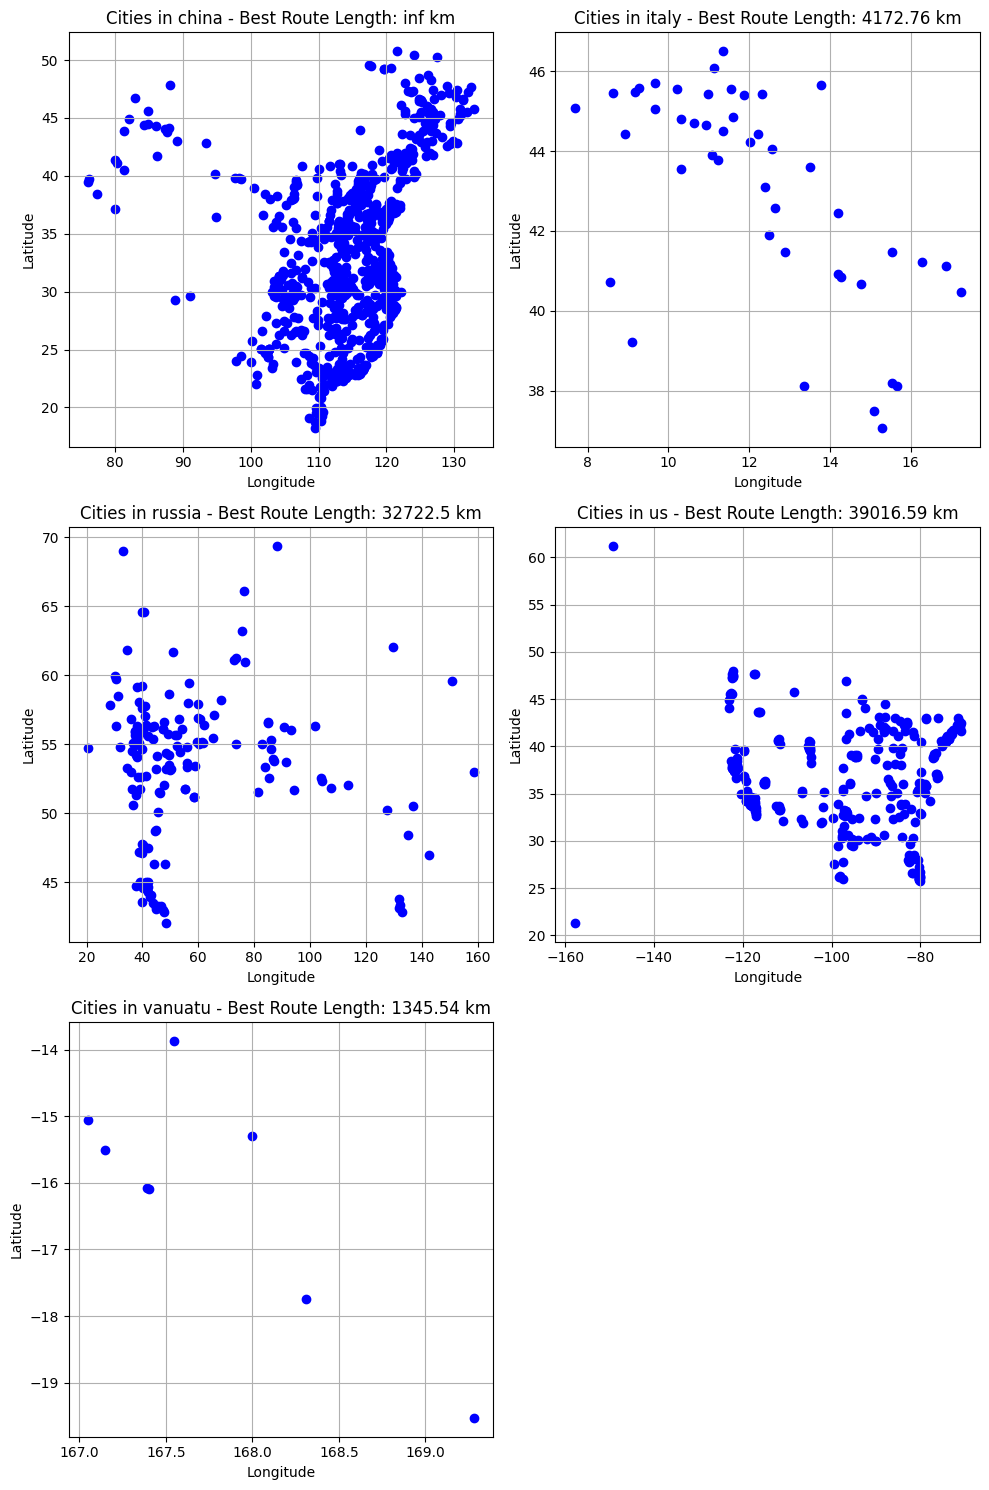

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
axs = axs.flatten()

for i, country_name in enumerate(city_by_country_dataframes):
    country_data = city_by_country_dataframes[country_name]
    axs[i].scatter(country_data["lon"], country_data["lat"], c="blue", marker="o")
    # To display the city names, but since a lot of cities
    # are displayed close together, it is not readable
    # for _, city in country_data.iterrows():
    #     axs[i].text(city["lon"], city["lat"], city["name"], fontsize=9)
    axs[i].set_xlabel("Longitude")
    axs[i].set_ylabel("Latitude")
    axs[i].set_title(
        f"Cities in {country_name} - Best Route Length: {countries_with_solutions[country_name]}km"
    )
    axs[i].grid(True)

# Remove empty subplot in the bottom right position
fig.delaxes(axs[5])

plt.tight_layout()
plt.show()

## Output Folders

In [45]:
IMG_FOLDER: str = "imgs"
OUTPUT_FOLDER: str = "out"
FOLDERS: tuple = (IMG_FOLDER, OUTPUT_FOLDER)


def create_folder(path: str) -> bool:
    if os.path.exists(path):
        return False
    os.makedirs(path, exist_ok=True)
    return True


# If folder doesn"t exist create it,
# else delete all file inside of it to avoid corrupting the results
def reset_folder(folder_path: str) -> None:
    if not create_folder(folder_path):
        for filename in os.listdir(folder_path):
            file_path: str = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print("Failed to delete %s. Reason: %s" % (file_path, e))


for folder in FOLDERS:
    reset_folder(folder)

# Utility

In [46]:
def valid(solution: NDArray[np.int32], num_cities: int) -> bool:
    if np.isin(solution, -1).any() or solution[0] != solution[-1]:
        return False
    return len(set(solution)) == num_cities


def cost(solution: NDArray[np.int32], dist_matrix: NDArray[np.float64]) -> np.float64:
    if not isinstance(solution, (list, np.ndarray)) and len(solution) < 1:
        raise ValueError(f"Solution wrong type: {type(solution)}")
    cumulative_dist: np.float64 = np.float64(0)
    if not valid(solution, len(dist_matrix)):
        return np.float64(np.inf)
    for c1, c2 in zip(solution, solution[1:]):
        cumulative_dist += np.float64(dist_matrix[c1, c2])
    return cumulative_dist


def mutation(
    individual: NDArray[np.int32], p_multiple_mutation: float = 0.3
) -> NDArray[np.int32]:
    """
    Perform a mutation on an individual"s genome by moving a randomly selected subset of genes to a new position.
    # Parameters:
    individual (NDArray[np.int32]): The genome of the individual to mutate.
    p_multiple_mutation (float): Probability of multiple mutations (default is 0.3).
    # Returns:
    NDArray[np.int32]: The mutated genome.
    The mutation process involves:

        1. Selecting a random subset of genes from the genome.
        2. Creating a probability distribution for the new position of the selected subset.
        3. Moving the selected subset to the new position based on the probability distribution.
    """
    high: int = len(individual) - 1
    mutated_genome: NDArray[np.int32] = individual.copy()

    # Select a random amount of cities
    while True:
        start: int = np.random.randint(1, high)
        end: int = np.random.randint(1, high)
        # Selecting at least 2 cities
        if end - start >= 1:
            break

    subset_length: int = end - start
    subset_to_move: NDArray[np.int32] = mutated_genome[start:end]

    # Create a probability distribution for the new position
    positions: NDArray[np.int32] = np.arange(1, high - subset_length)
    distances: NDArray[np.int32] = np.abs(positions - start)
    # Higher probability for nearby positions
    probabilities: NDArray[np.float64] = np.exp(-distances)
    # Normalize to sum to 1
    probabilities /= probabilities.sum()

    # Select a new position for the subset
    new_position: NDArray[np.int32] = np.random.choice(positions, p=probabilities)

    # Move the subset to the new position
    if new_position < start:
        mutated_genome = np.concatenate(
            (
                mutated_genome[:new_position],
                subset_to_move,
                mutated_genome[new_position:start],
                mutated_genome[end:],
            )
        )
    else:
        mutated_genome = np.concatenate(
            (
                mutated_genome[:start],
                mutated_genome[end : new_position + subset_length],
                subset_to_move,
                mutated_genome[new_position + subset_length :],
            )
        )

    return mutated_genome


def get_elites_from_population(
    population: NDArray[np.int32],
    dist_matrix: NDArray[np.float64],
    k: int = 2,
) -> NDArray[np.int32]:
    population_cost: NDArray[np.float64] = np.array(
        [cost(individual, dist_matrix) for individual in population]
    )
    sorted_indices: NDArray[np.int32] = np.argsort(population_cost)

    sorted_population: NDArray[np.int32] = population[sorted_indices]
    return sorted_population[:k]


def xover(
    p1: NDArray[np.int32], p2: NDArray[np.int32], num_cities: int, mutation_rate: float
) -> NDArray[np.int32]:
    mask: NDArray[np.bool] = np.random.rand(p1.size) < 0.5
    # Choosing wrap-around city to be from parent 1 (parent 2 would work as well)
    mask[0] = mask[-1] = True
    child: NDArray[np.int32] = np.full(p1.size, -1, dtype=np.int32)
    child[mask] = p1[mask]
    for i in range(child.size):
        p2_idx = 0
        # when finding a not selected city in the child (value -1)
        # search for the first not already visited city from parent 2
        if child[i] == -1:
            for p2_idx in range(p2.size):
                if p2[p2_idx] in child:
                    continue
                child[i] = p2[p2_idx]
                break

    if np.random.rand() < mutation_rate:
        # logging.debug("Mutating...")
        child = mutation(child)

    # The mutation will always return a valid child, if not interrupt immediately and debug
    assert valid(child, num_cities), f"""
Invalid child: {child}
p1:            {p1}
p2:            {p2}
"""
    return child


def generate_random_combinations(
    num_individuals: int, num_combinations: int
) -> NDArray[np.int32]:
    # Start from 1 to avoid division by zero
    values = np.arange(1, num_individuals + 1)

    # Assign higher probability to the lower value (fittest individual) and normalize the probabilities
    probabilities = 1 / values
    probabilities /= probabilities.sum()

    # Generate random combinations using the probability distribution
    random_combinations = np.random.choice(
        values, (num_combinations, 2), p=probabilities
    )

    # fix indexing starting with 0
    random_combinations = random_combinations - 1
    return random_combinations - 1

In [47]:
len(np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]))

2

## Visual Utility

In [ ]:
def save_solution(
    country: pd.DataFrame,
    solution: NDArray[np.int32],
    dist_matrix: NDArray[np.float64],
    gen: int,
    algo_name: str,
    country_name: str,
    img_name_scheme: str = "gen",
    display: bool = False,
) -> None:
    # Multi-platform (Windows, Unix) handling of folders
    # double concatenate  e.g.
    # imgs,family_trip,italy -> imgs/family_trip italy -> imgs/family_trip/italy
    out_path: str = os.path.join(os.path.join(IMG_FOLDER, algo_name), country_name)
    # Assuming the notebook is run from the start and the folder is already sterilized
    create_folder(out_path)
    path_lons = [country.iloc[city]["lon"] for city in solution]
    path_lats = [country.iloc[city]["lat"] for city in solution]
    plt.figure(figsize=(10, 8))
    plt.scatter(country["lon"], country["lat"], c="blue", marker="o")
    for _, city in country.iterrows():
        plt.text(city["lon"], city["lat"], city["name"], fontsize=9)
    plt.plot(
        path_lons,
        path_lats,
        c="blue",
        linestyle="-",
        linewidth=1,
        marker="o",
        markerfacecolor="red",
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(
        f"Best Travel Path - Generation {gen} - Path Len {cost(solution, dist_matrix):.2f}km"
    )
    plt.grid(True)
    # plt.savefig(f"{out_folder_name}/gen_{gen}.png")
    plt.savefig(os.path.join(out_path, f"{img_name_scheme}_{gen}.png"))
    if display:
        plt.show()
    plt.close()


def sorted_alphanumeric(data):
    def convert(text):
        return int(text) if text.isdigit() else text.lower()

    def alphanum_key(key):
        return [convert(c) for c in re.split("([0-9]+)", key)]

    return sorted(data, key=alphanum_key)


def make_video(
    algo_name: str, country_name: str, video_name: str | None = None
) -> None:
    # Multiplatform (Windows, Unix) handling of folders
    input_path: str = os.path.join(os.path.join(IMG_FOLDER, algo_name), country_name)
    if video_name is not None:
        out_file_path: str = os.path.join(OUTPUT_FOLDER, f"{video_name}.avi")
    else:
        out_file_path: str = os.path.join(OUTPUT_FOLDER, f"{country_name}.avi")

    images = [
        img
        for img in sorted_alphanumeric(os.listdir(input_path))
        if img.endswith(".png")
    ]
    frame = cv2.imread(os.path.join(input_path, images[0]))
    height, width, _ = frame.shape

    video = cv2.VideoWriter(out_file_path, 0, 30, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(input_path, image)))

    cv2.destroyAllWindows()
    video.release()


def filter_generation_history(
    generation_history: NDArray[np.float64],
) -> NDArray[np.int32]:
    # Filter out rows with more than three zeros
    valid_rows = np.array(
        [row for row in generation_history if np.count_nonzero(row == 0) <= 3]
    )
    return valid_rows


def plot_cost_history(cost_history: NDArray[np.float64]) -> None:
    # Accomodate algorithm find a early solution
    filtered_history = filter_generation_history(cost_history)

    plt.figure(figsize=(10, 6))
    plt.plot(filtered_history, label="Cost History")
    plt.xlabel("Generation")
    plt.ylabel("Cost")
    plt.title("Cost History Over Generations")
    plt.legend()
    plt.grid(True)

    # Increase resolution on the y-axis
    min_cost = filtered_history.min()
    max_cost = filtered_history.max()
    y_ticks = np.linspace(
        min_cost, max_cost, num=20
    )  # Adjust num for more or fewer ticks
    plt.yticks(y_ticks)

    # Increase resolution on the x-axis
    num_generations = len(filtered_history)
    x_ticks = np.linspace(
        0, num_generations - 1, num=20, dtype=int
    )  # Adjust num for more or fewer ticks
    plt.xticks(x_ticks)

    plt.show()


def save_and_make_video(
    evolution: NDArray[np.int32],
    dist_matrix: NDArray[np.float64],
    country_name: str,
    video_name: str | None = None,
) -> None:
    algo_name = "family_trip"

    logging.info("Saving the evolution...")
    Parallel(n_jobs=int(cpu_count()), prefer="processes")(
        delayed(save_solution)(
            country=city_by_country_dataframes[country_name],
            solution=evolution[gen],
            dist_matrix=dist_matrix,
            gen=gen,
            algo_name=algo_name,
            country_name=country_name,
        )
        for gen in tqdm(range(len(evolution)))
    )

    logging.info("Rendering Video...")
    make_video(algo_name=algo_name, country_name=country_name, video_name=video_name)
    logging.info("Done!")

# Solution

## Family Trip

In [49]:
def family_trip(
    country_name: str,
    cities: pd.DataFrame,
    dist_matrix: NDArray[np.float64],
    population_size: int,
    mutation_rate: float,
    num_elites: int,
    num_generations: int,
) -> tuple[int, NDArray[np.int32], NDArray[np.float64]]:
    assert country_name in COUNTRY_NAMES, f"Invalid country name: {country_name}"
    num_cities = len(cities)

    # Initialize population with random permutations of cities and make path circular
    population: NDArray[np.int32] = np.array(
        [np.random.permutation(num_cities) for _ in range(population_size)]
    )
    first_city: NDArray[np.int32] = population[:, 0].reshape(-1, 1)
    population = np.hstack((population, first_city))

    # Initialize two history arrays to store
    # - best individual for each generations
    # - cost history
    best_evolution: NDArray[np.int32] = np.zeros(
        (num_generations, num_cities + 1), dtype=np.int32
    )
    cost_history: NDArray[np.float64] = np.zeros(num_generations, dtype=np.float64)

    # Validate the initial population
    # i.e. all individuals must have unique cities and start and end at the same city
    for i in range(len(population)):
        assert valid(
            population[i], len(dist_matrix)
        ), f"Invalid individual {i}th: {population[i]}"

    # Initialize tqdm progress bar
    progress_bar = tqdm(range(num_generations), desc="Starting", unit="gen")

    for gen in progress_bar:
        best_evolution[gen] = population[
            np.argmin([cost(individual, dist_matrix) for individual in population])
        ]
        cost_history[gen] = cost(best_evolution[gen], dist_matrix)

        # some country e.g. china has no known solution
        if (
            countries_with_solutions[country_name] != np.inf
            and cost_history[gen] - countries_with_solutions[country_name] < 0.01
        ):
            logging.info(
                f"SOLUTION FOUND!: Generation {gen}: total length {cost_history[gen]:.2f}km, valid: {valid(best_evolution[gen], len(dist_matrix))}"
            )
            return gen, best_evolution, cost_history

        progress_bar.set_description(f"Gen {gen} Best Cost: {cost_history[gen]:.2f}km")

        elites: NDArray[np.int32] = get_elites_from_population(
            population, dist_matrix, num_elites
        )
        random_elites_combinations: NDArray[np.int32] = generate_random_combinations(
            num_elites, population_size
        )
        # Recreate population for the fittest
        for n in range(population_size):
            i1, i2 = random_elites_combinations[n]
            # crossover from two parent with mutation and reshape the output into a row
            child: NDArray[np.int32] = xover(
                elites[i1], elites[i2], len(dist_matrix), mutation_rate=mutation_rate
            ).reshape(1, -1)
            population = np.append(population, child, axis=0)
        # TODO: consider initialize population as population_size * NUM_GENERATIONS
        # and for each iteration translate the view of the array
        population = population[-population_size:].copy()

    best_traveler: NDArray[np.int32] = population[
        np.argmin([cost(individual, dist_matrix) for individual in population])
    ]
    logging.info(
        f"Result: Found a path of {len(best_traveler)-1} steps, total length {cost(best_traveler, dist_matrix):.2f}km, valid: {valid(best_traveler, len(dist_matrix))}"
    )
    return num_generations, best_evolution, cost_history

In [50]:
logging.basicConfig(format="%(levelname)s: %(message)s", level=logging.INFO)

POPULATION_SIZE = 50
MUTATION_RATE = 0.4
NUM_ELITES = 3
NUM_GENERATIONS = 200

problem_params = {}
for country_name in COUNTRY_NAMES:
    match country_name:
        # reduce the problem size for china to speed up the computation
        case "china":
            problem_params[country_name] = {
                "population_size": 20,
                "mutation_rate": 0.5,
                "num_elites": 2,
                "num_generations": 50,
            }
        case "italy" | "russia" | "us" | "vanuatu":
            problem_params[country_name] = {
                "population_size": POPULATION_SIZE,
                "mutation_rate": MUTATION_RATE,
                "num_elites": NUM_ELITES,
                "num_generations": NUM_GENERATIONS,
            }
        case _:
            raise ValueError(f"Sorry, I didn't consider this country: {country_name}")

In [ ]:
final_results = {}

for country_name in COUNTRY_NAMES:
    cities: pd.DataFrame = city_by_country_dataframes[country_name]
    dist_matrix: NDArray[np.float64] = countries_dist_matrices[country_name]
    logging.info(f"Running for {country_name}...")
    generations_computed, best_evolution, cost_history = family_trip(
        country_name=country_name,
        dist_matrix=dist_matrix,
        cities=cities,
        population_size=problem_params[country_name].get("population_size"),
        mutation_rate=problem_params[country_name].get("mutation_rate"),
        num_elites=problem_params[country_name].get("num_elites"),
        num_generations=problem_params[country_name].get("num_generations"),
    )
    final_results[country_name] = {
        "population_size": problem_params[country_name].get("population_size"),
        "mutation_rate": problem_params[country_name].get("mutation_rate"),
        "num_elites": problem_params[country_name].get("num_elites"),
        "num_generations": generations_computed,
        "final_cost": cost_history[generations_computed],
    }
    # plot_cost_history(cost_history)
    save_and_make_video(best_evolution, dist_matrix, country_name)

INFO: Running for china...


Starting:   0%|          | 0/50 [00:00<?, ?gen/s]

INFO: Result: Found a path of 726 steps, total length 876605.29km, valid: True
INFO: Saving the evolution...


  0%|          | 0/50 [00:00<?, ?it/s]

INFO: Rendering Video...
INFO: Done!
INFO: Running for italy...


Starting:   0%|          | 0/200 [00:00<?, ?gen/s]

INFO: Result: Found a path of 46 steps, total length 6473.74km, valid: True
INFO: Saving the evolution...


  0%|          | 0/200 [00:00<?, ?it/s]

INFO: Rendering Video...
INFO: Done!
INFO: Running for russia...


Starting:   0%|          | 0/200 [00:00<?, ?gen/s]

INFO: Result: Found a path of 167 steps, total length 131595.99km, valid: True
INFO: Saving the evolution...


  0%|          | 0/200 [00:00<?, ?it/s]

INFO: Rendering Video...
INFO: Done!
INFO: Running for us...


Starting:   0%|          | 0/200 [00:00<?, ?gen/s]

INFO: Result: Found a path of 326 steps, total length 325068.97km, valid: True
INFO: Saving the evolution...


  0%|          | 0/200 [00:00<?, ?it/s]

INFO: Rendering Video...
INFO: Done!
INFO: Running for vanuatu...


Starting:   0%|          | 0/200 [00:00<?, ?gen/s]

INFO: SOLUTION FOUND!: Generation 7: total length 1345.54km, valid: True
INFO: Saving the evolution...


  0%|          | 0/200 [00:00<?, ?it/s]

INFO: Rendering Video...
INFO: Done!


In [53]:
final_results[country_name] = {
        "population_size": problem_params[country_name].get("population_size"),
        "mutation_rate": problem_params[country_name].get("mutation_rate"),
        "num_elites": problem_params[country_name].get("num_elites"),
        "num_generations": generations_computed,
        "final_cost": cost_history[generations_computed],
    }

In [54]:
print(
    "|Country|Population Size|Mutation Rate|Num Elites|Num Generations|Final Cost|Known Solution|"
)
print("|---|---|---|---|---|---|---|")
for country_name, result in final_results.items():
    print(
        f"|{country_name}|{result['population_size']}|{result['mutation_rate']}|{result['num_elites']}|{result['num_generations']}|{result['final_cost']:.2f}km|{countries_with_solutions[country_name]}|"
    )

|Country|Population Size|Mutation Rate|Num Elites|Num Generations|Final Cost|Known Solution|
|---|---|---|---|---|---|---|
|china|20|0.5|2|50|877373.82km|inf|
|italy|50|0.4|3|200|6473.74km|4172.76|
|russia|50|0.4|3|200|131595.99km|32722.5|
|us|50|0.4|3|200|326431.43km|39016.59|
|vanuatu|50|0.4|3|7|1345.54km|1345.54|
